In [91]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# timevae / fourierflows
model = 'fourierflows'
n_best = 9

In [93]:
# select all files ending with 'distance' or 'feature'
files = os.listdir('./TSGBench/data/' + model)
files = [file for file in files if file.endswith('distance.pkl') or file.endswith('feature.pkl')]

In [94]:
# read all files, compute mean of all values, and reshape the data
# we compute the mean because mdd and acd are reported as the values over 5 runs
# single-value metrics will not be effected by computing the average
results = []
for i,file in enumerate(files):
    with open('./TSGBench/data/' + model + '/' + file, 'rb') as file:
        data = pickle.load(file)    
    for x in data:
        results.append(np.mean(x))
results = np.array(results)
results = results.reshape(-1, 6)

In [95]:
# compute rankings 
ranks = results.argsort(axis=0).argsort(axis=0)

In [96]:
# compute median rankings
medians = [np.median(rank) for rank in ranks]

In [97]:
# find n_best ranked models
min_med_rank_indices = np.argsort(medians)[:n_best]
best_models = []
for i,file in enumerate(np.array(files[::2])[min_med_rank_indices]):
    file = file.removeprefix('fmri_')
    file = file.removesuffix('_eval_distance.pkl')
    best_models.append(file)
    print(i+1, file)

1 150_15_0.001
2 250_15_0.001
3 200_10_0.001
4 150_10_0.001
5 250_10_0.001
6 150_5_0.001
7 200_5_0.0001
8 250_5_0.0001
9 250_10_0.0001


In [98]:
labels = [label.split('_') for label in best_models]
labels = np.array(labels)

rows, cols = labels.shape
new_array = []
for row in range(rows):
    for col in range(cols):
        new_array.append(len(labels[row, col]))
new_array = np.array(new_array)
new_array = new_array.reshape(-1, cols)

paddings = np.max(new_array, axis=0) - new_array 

for row in range(rows):
    for col in range(cols):
        labels[row, col] += '' * paddings[row, col]

In [101]:
def load(data):
    try:
        data = data['data']
    except:
        data = data['arr_0']
    return data

In [102]:
# plot first synthetic motion curve of each of the n_best models
if False:
    fig, axs = plt.subplots(n_best, 1, figsize=(8, n_best * 2))
    categories = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
    for i in range(n_best):
        file = f'TSGBench/data/{model}/fmri_{best_models[i]}_gen.npz'
        data = np.load(file)
        data = load(data)
        for d in range(6):
            axs[i].plot(data[0, :, d], label=categories[d])
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [103]:
def radar_chart(data, data_labels, feature_labels, model='timevae'):
    # Number of variables
    num_vars = len(feature_labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "complete the loop" and append the start value to the end.
    data = np.concatenate((data, data[:,[0]]), axis=1)
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i in range(len(data)):
        labels = data_labels[i]
        if model == 'timevae':
            # label = ' '.join([f'{key} = {val}' for key, val in zip(['ls', 'ld', 'tp', 'lr'], data_labels[i])])
            label = f'ls = {labels[0]}, ld = {labels[1]}, tp = {labels[2]}, lr = {labels[3]}'
        if model == 'fourierflows':
            label = f'ls = {labels[0]}, nf = {labels[1]}, lr = {labels[2]}'
        ax.plot(angles, data[i]+1, linewidth=2, linestyle='solid', marker='o', markersize=5, label=label)

    
    # Background color with alpha
    bg_color = (0, 0, 1, 0.05)  # light blue with specified alpha
    ax.set_facecolor(bg_color)

    # Change arm color to white
    for line in ax.get_ygridlines():
        line.set_color('white')
    for line in ax.get_xgridlines():
        line.set_color('white')

    # Labels
    ax.set_yticks([i for i in range(1, len(data)+1)])
    ax.set_yticklabels([str(i) for i in range(len(data), 0, -1)])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels)

    # Add legend 
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35))   
    plt.savefig('ass.png')

    # Show plot
    plt.show()

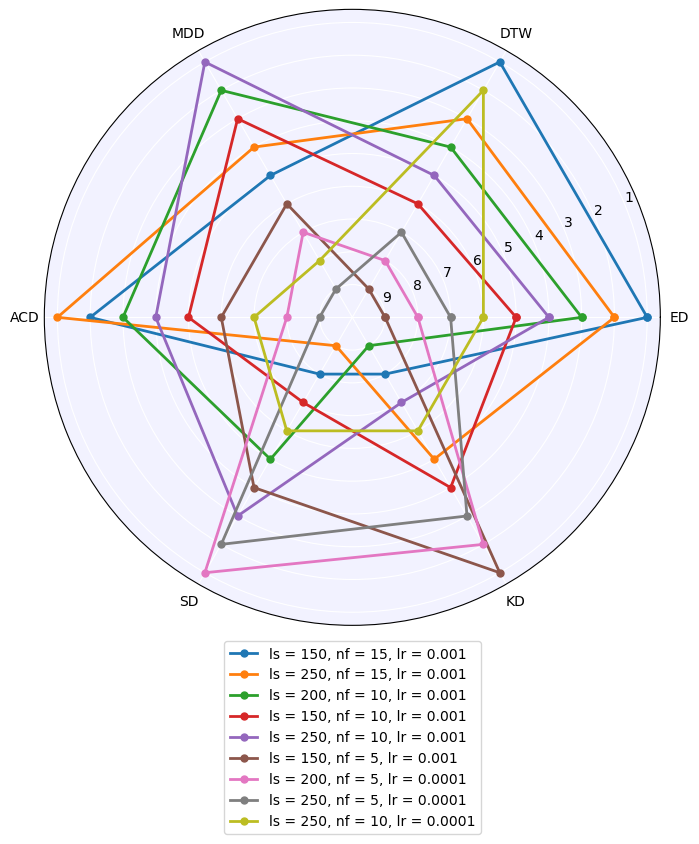

In [104]:
data = len(ranks[min_med_rank_indices]) - 1 - ranks[min_med_rank_indices].argsort(axis=0).argsort(axis=0)
data_labels = labels
feature_labels = ['ED', 'DTW', 'MDD', 'ACD', 'SD', 'KD']

# Plot radar chart
radar_chart(data, data_labels, feature_labels, model)